# Analyse SHAP values

In [1]:
PATH = "/home/WUR/katz001/PROJECTS/permit-nsti-gas"

import os
import numpy as np
import json
import pandas as pd
import sys 
import errno  
import seaborn as sns
sys.path.append(f"{PATH}/scripts")

import matplotlib.pyplot as plt 
from func_preprocess import pipe_imputation_scaling, pipe_supervisedSelector
import shap
import pickle

from sklearn.pipeline import Pipeline

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, brier_score_loss, roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from statkit import decision

/home/WUR/katz001/miniconda3/envs/env_permit_gas/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Read dataset and split
''' 
Prepare data --> change here for different setups!
'''
datasetTimepoint = "BL"
target = "Conclusion_micro"
percentBoruta = 100
n_iter = 1000

''' 
Select features
'''
vars = f"{target}_bootstrapped_iterativeBoruta_{percentBoruta}perc"    
varPath = f"{PATH}/results/20_featureSelection/{datasetTimepoint}/CV/{vars}.txt"
sel_variables = pd.read_csv(varPath, header=None)[0].tolist()

''' 
Define paths
'''
folderFigures = f"{PATH}/figures/{datasetTimepoint}/40_internalValidation"
resultsPath = f"{PATH}/results/40_internalValidation/{datasetTimepoint}/"
dataPath = f"{PATH}/results/10_preprocessed"
dataset = f"{datasetTimepoint}_{target}_preprocessed.csv"

''' 
Split data
'''

with open(f"{PATH}/data/data_dtypes.json", "r") as f:
    dtypes = json.load(f)
data = pd.read_csv(f"{dataPath}/{dataset}", index_col=0, dtype=dtypes)
tmp = data.select_dtypes(include=["float32"]).columns 
data[tmp] = data[tmp].astype(pd.Int64Dtype())

X = data.drop(target, axis=1)
y = data[target]

In [3]:
''' Load predProba'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_{model}_n{n_iter}_predProba.pickle', 'rb') as f:
    dic_proba = pickle.load(f)
data = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T

In [43]:
dic_performanceScores = {
    "acc":np.array([]),
    "prec":np.array([]),
    "recall":np.array([]),
    "f1-score":np.array([]),
    "brier":np.array([]),
    "roc_auc":np.array([]),
    "pr":np.array([]),
}
for run in range(data.shape[1]):
    predproba = data[run][data[run].notna()]
    pred = predproba.copy()
    pred[predproba < 0.5] = 0
    pred[predproba >= 0.5] = 1
    tru = y.loc[predproba.index]   
    
    ## Accuracy
    dic_performanceScores["acc"] = np.append(dic_performanceScores["acc"],balanced_accuracy_score(tru, pred))
    ## Precision
    dic_performanceScores["prec"] = np.append(dic_performanceScores["prec"],precision_score(tru, pred))
    ## Recall
    dic_performanceScores["recall"] = np.append(dic_performanceScores["recall"],recall_score(tru, pred))
    # F1-score
    dic_performanceScores["f1-score"] = np.append(dic_performanceScores["f1-score"],f1_score(tru, pred))
    ## Brier
    dic_performanceScores["brier"] = np.append(dic_performanceScores["brier"],brier_score_loss(tru, predproba))
    ## ROC AUC
    dic_performanceScores["roc_auc"] = np.append(dic_performanceScores["roc_auc"],roc_auc_score(tru, predproba))
    ## PR
    dic_performanceScores["pr"] = np.append(dic_performanceScores["pr"],average_precision_score(tru, predproba))

df_scores = pd.DataFrame.from_dict(dic_performanceScores)

""" 
Calculate confidence intervals 
"""
for col in df_scores.columns:
    print(col, np.mean(df_scores[col]),np.percentile(df_scores[col], 2.5), np.percentile(df_scores[col], 97.5))

acc 0.7272674077295547 0.6582661139835796 0.7985133763256669
prec 0.7286933240344134 0.6 0.8666666666666667
recall 0.5467047898488455 0.3962165880503145 0.7
f1-score 0.6205066579312298 0.5 0.7294117647058823
brier 0.14723919006116043 0.12519700816776708 0.17173879189476524
roc_auc 0.8390914300269937 0.7786928676851889 0.8936964319457942
pr 0.7026892861921819 0.5915466158893364 0.8071442546239778


# Calculate CI

In [44]:
""" 
Calculate confidence intervals 
"""
df_ci = pd.DataFrame()
for col in df_scores.columns:
    df_ci[col] = np.array([np.mean(df_scores[col]),np.percentile(df_scores[col], 2.5), np.percentile(df_scores[col], 97.5)])
df_ci.index = ["mean", "lower_CI", "upper_CI"]

#### Save to file
df_ci.to_csv(f"{resultsPath}/bootstrap_CI_95%.csv")

In [45]:
for i, col in enumerate(df_ci.columns):
    print(col)
    print("%.3f" % df_ci.iloc[0, i], "(95%CI", "%.3f," % df_ci.iloc[1, i], "%.3f)" % df_ci.iloc[2, i])
    print("\n")

acc
0.727 (95%CI 0.658, 0.799)


prec
0.729 (95%CI 0.600, 0.867)


recall
0.547 (95%CI 0.396, 0.700)


f1-score
0.621 (95%CI 0.500, 0.729)


brier
0.147 (95%CI 0.125, 0.172)


roc_auc
0.839 (95%CI 0.779, 0.894)


pr
0.703 (95%CI 0.592, 0.807)




# Net benefit

In [46]:
df_scores

,acc,prec,recall,f1-score,brier,roc_auc,pr
0,0.767602,0.771429,0.613636,0.683544,0.131198,0.868761,0.789117
1,0.721316,0.821429,0.489362,0.613333,0.135416,0.876516,0.739041
2,0.680654,0.904762,0.380000,0.535211,0.156049,0.850467,0.724032
3,0.730050,0.705882,0.558140,0.623377,0.146296,0.828317,0.706904
4,0.763303,0.771429,0.600000,0.675000,0.131032,0.888889,0.726064
...,...,...,...,...,...,...,...
995,0.653966,0.680000,0.386364,0.492754,0.172388,0.759804,0.608333
996,0.667614,0.760000,0.395833,0.520548,0.144774,0.877315,0.766392
997,0.794504,0.775000,0.673913,0.720930,0.132778,0.856645,0.807141
998,0.725553,0.757576,0.531915,0.625000,0.151020,0.841178,0.703241


# Net benefit

(-0.1, 0.33)

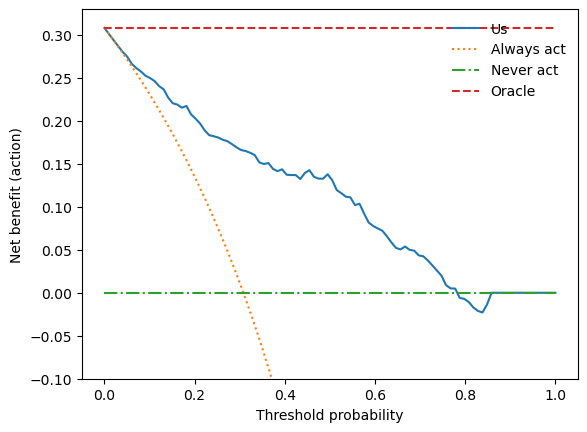

In [4]:
b = data.T.mean().sort_index()
c = y.loc[b.index]

fig, ax = plt.subplots()
decision.NetBenefitDisplay.from_predictions(c, b, name='Us', ax=ax)
ax.set_ylim(0-.1,.33)